# The Battle of Neighborhoods 
# Finding Good Housing Price and Good School Rating in North York, Toronto

### 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2.  Data Extraction and Cleaning
Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [34]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [35]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [36]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df[df['Borough']=="North_York"].head()

,Postalcode,Borough,Neighborhood


In [37]:
df['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

In [38]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M9R,North York,Downsview
freq,1,24,4


In [39]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [40]:
df.isnull().sum()

Postalcode      0
Borough         0
Neighborhood    0
dtype: int64

In [41]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Borough', 'Postalcode'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [42]:
df_2.describe()

,Borough,Postalcode,Neighborhood
count,103,103,103
unique,10,103,99
top,North York,M9R,Downsview
freq,24,1,4


In [212]:
print(df_2.shape)

(103, 5)


In [215]:
# to get the list of North York index
df_2[df_2['Borough'] == 'North York'].index

Int64Index([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74],
           dtype='int64')

In [214]:
df_2[df_2['Borough'] == 'North York'] 

,Borough,Postalcode,Neighborhood,Latitude,Longitude
51,North York,M2H,Hillcrest Village,43.80225,-79.35558
52,North York,M2J,"Fairview, Henry Farm, Oriole",43.78097,-79.34781
53,North York,M2K,Bayview Village,43.78112,-79.38060
54,North York,M2L,"York Mills, Silver Hills",43.75698,-79.38060
55,North York,M2M,"Willowdale, Newtonbrook",43.79182,-79.41372
56,North York,M2N,"Willowdale, Willowdale East",43.76774,-79.40728
57,North York,M2P,York Mills West,43.74778,-79.40033
58,North York,M2R,"Willowdale, Willowdale West",43.77989,-79.44678
59,North York,M3A,Parkwoods,43.75245,-79.32991
60,North York,M3B,Don Mills,43.74923,-79.36186


In [44]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M2H')

[43.80225000000007, -79.35557999999997]

In [45]:
postal_codes = df_2['Postalcode']
df_2.head()

,Borough,Postalcode,Neighborhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [46]:
# Retrieving Postal Code Co-ordinates
coords = []
for postal_code in postal_codes.tolist():
    coords.append(get_latilong(postal_code))

In [47]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [48]:
df_2[df_2.Postalcode == 'M2H']

,Borough,Postalcode,Neighborhood,Latitude,Longitude
51,North York,M2H,Hillcrest Village,43.80225,-79.35558


In [49]:
df_2[df_2['Borough'] == 'North York'].head(10)

,Borough,Postalcode,Neighborhood,Latitude,Longitude
51,North York,M2H,Hillcrest Village,43.80225,-79.35558
52,North York,M2J,"Fairview, Henry Farm, Oriole",43.78097,-79.34781
53,North York,M2K,Bayview Village,43.78112,-79.38060
54,North York,M2L,"York Mills, Silver Hills",43.75698,-79.38060
55,North York,M2M,"Willowdale, Newtonbrook",43.79182,-79.41372
56,North York,M2N,"Willowdale, Willowdale East",43.76774,-79.40728
57,North York,M2P,York Mills West,43.74778,-79.40033
58,North York,M2R,"Willowdale, Willowdale West",43.77989,-79.44678
59,North York,M3A,Parkwoods,43.75245,-79.32991
60,North York,M3B,Don Mills,43.74923,-79.36186


In [50]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent="smy-application")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print(f"The Geograpical Co-ordinate of North York, Toronto are {latitude_x}, {longitude_y}.")

The Geograpical Co-ordinate of North York, Toronto are 43.7543263, -79.44911696639593.


### 3. Map of North York

In [51]:
map_North_York = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_North_York)  
    
map_North_York

In [54]:
address = 'North York'

geolocator = Nominatim(user_agent="smy-application")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


In [60]:
# @hidden_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' 
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B'
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [62]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [63]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [64]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [65]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
3,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686
5,Popeyes Louisiana Kitchen,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.754671,-79.442740
6,Times Square Diner,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",43.751058,-79.455591
7,Pizza Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.755311,-79.441126
8,Wakame Sushi,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",43.755382,-79.440945
9,TTC Bus 84 Sheppard West,"[{'id': '4bf58dd8d48988d12b951735', 'name': 'B...",43.751970,-79.455324


### 5. Categories of Nearby Venues/Locations

In [66]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
3,Tim Hortons,Coffee Shop,43.754767,-79.443250
4,Bagel Plus,Restaurant,43.755395,-79.440686
5,Popeyes Louisiana Kitchen,Fried Chicken Joint,43.754671,-79.442740
6,Times Square Diner,American Restaurant,43.751058,-79.455591
7,Pizza Pizza,Pizza Place,43.755311,-79.441126
8,Wakame Sushi,Sushi Restaurant,43.755382,-79.440945
9,TTC Bus 84 Sheppard West,Bus Line,43.751970,-79.455324


In [67]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  2
Bus Line                     1
Sushi Restaurant             1
Restaurant                   1
Middle Eastern Restaurant    1
American Restaurant          1
Coffee Shop                  1
Mediterranean Restaurant     1
Fried Chicken Joint          1
Deli / Bodega                1
Name: categories, dtype: int64

In [68]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [69]:
# Nearby Venues
North_York_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter

In [70]:
print('There are {} Uniques Categories.'.format(len(North_York_venues['Venue Category'].unique())))
North_York_venues.groupby('Neighborhood').count().head(10)

There are 307 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,24,24,24,24,24,24
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",12,12,12,12,12,12
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",6,6,6,6,6,6
"Brockton, Parkdale Village, Exhibition Place",92,92,92,92,92,92
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100


### One Hot Encoding of Features

In [94]:
# one hot encoding
North_York_onehot = pd.get_dummies(North_York_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
North_York_onehot['Neighborhood'] = North_York_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [North_York_onehot.columns[-1]] + list(North_York_onehot.columns[:-1])
North_York_onehot = North_York_onehot[fixed_columns]
North_York_grouped = North_York_onehot.groupby('Neighborhood').mean().reset_index()
North_York_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning

In [95]:
num_top_venues = 5
for hood in North_York_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =North_York_grouped[North_York_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.08
1                Park  0.04
2            Pharmacy  0.04
3  Chinese Restaurant  0.04
4      Clothing Store  0.04


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store  0.11
1                Gym  0.11
2        Pizza Place  0.11
3        Coffee Shop  0.11
4           Pharmacy  0.11


---- Bathurst Manor, Wilson Heights, Downsview North ----
               venue  freq
0        Coffee Shop  0.17
1               Park  0.08
2   Sushi Restaurant  0.08
3  Mobile Phone Shop  0.08
4      Deli / Bodega  0.08


---- Bayview Village ----
              venue  freq
0              Park   0.2
1  Asian Restaurant   0.2
2       Flower Shop   0.2
3             Trail   0.2
4       Gas Station   0.2


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2         Coffee Shop  0.08
3         Pizza Place  0.08
4   Indian Restaurant  

         venue  freq
0  Coffee Shop  0.11
1        Hotel  0.06
2         Café  0.06
3   Restaurant  0.04
4          Bar  0.03


---- Studio District ----
                venue  freq
0         Coffee Shop  0.07
1                 Bar  0.05
2              Bakery  0.05
3               Diner  0.05
4  Italian Restaurant  0.04


---- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ----
          venue  freq
0   Coffee Shop  0.12
1  Skating Rink  0.12
2          Park  0.06
3    Restaurant  0.06
4    Bagel Shop  0.06


---- The Annex, North Midtown, Yorkville ----
                venue  freq
0      Sandwich Place  0.07
1      History Museum  0.07
2  Italian Restaurant  0.07
3                Café  0.07
4         Coffee Shop  0.07


---- The Beaches ----
             venue  freq
0              Pub  0.09
1  Thai Restaurant  0.05
2      Cheese Shop  0.05
3           Church  0.05
4         Tea Room  0.05


---- The Danforth West, Riverdale ----
                       venue  freq
0 

In [111]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [193]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(f"{ind+1}{indicators[ind]} Most Common Venue")
    except:
        columns.append(f"{ind+1}th Most Common Venue")

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = North_York_grouped['Neighborhood']

for ind in np.arange(North_York_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(North_York_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pool,Bakery,Sushi Restaurant,Latin American Restaurant,Supermarket,Breakfast Spot,Bubble Tea Shop,Skating Rink,Shanghai Restaurant
1,"Alderwood, Long Branch",Convenience Store,Pizza Place,Sandwich Place,Gym,Pharmacy,Coffee Shop,Print Shop,Pub,Gas Station,Event Space
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Park,Mobile Phone Shop,Mediterranean Restaurant,Pizza Place,Middle Eastern Restaurant,Deli / Bodega,Restaurant,Sandwich Place,Fried Chicken Joint
3,Bayview Village,Gas Station,Flower Shop,Park,Trail,Asian Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
4,"Bedford Park, Lawrence Manor East",Pizza Place,Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Intersection,Butcher,Café,Sports Club,Liquor Store


### K-Means Clustering Approach

In [194]:
North_York_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning

In [195]:
# Using K-Means to cluster neighborhood into 3 clusters
North_York_grouped_clustering = North_York_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=101).fit(North_York_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [196]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

North_York_merged =df_2.iloc[51:75,:] # North York Borough index is 51 to 74

In [197]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
North_York_merged = North_York_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

North_York_merged

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,North York,M2H,Hillcrest Village,43.80225,-79.35558,2,Park,Pharmacy,Residential Building (Apartment / Condo),Chinese Restaurant,Bakery,Fast Food Restaurant,Elementary School,Donut Shop,Dumpling Restaurant,Fish & Chips Shop
52,North York,M2J,"Fairview, Henry Farm, Oriole",43.78097,-79.34781,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Juice Bar,Women's Store,Restaurant,Bank,Toy / Game Store,Shoe Store
53,North York,M2K,Bayview Village,43.78112,-79.38060,0,Gas Station,Flower Shop,Park,Trail,Asian Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
54,North York,M2L,"York Mills, Silver Hills",43.75698,-79.38060,2,Concert Hall,Park,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Farm
55,North York,M2M,"Willowdale, Newtonbrook",43.79182,-79.41372,0,Korean Restaurant,Middle Eastern Restaurant,Coffee Shop,Café,Pizza Place,Diner,Japanese Restaurant,Sandwich Place,Sushi Restaurant,Fried Chicken Joint
56,North York,M2N,"Willowdale, Willowdale East",43.76774,-79.40728,0,Coffee Shop,Japanese Restaurant,Pizza Place,Ramen Restaurant,Fast Food Restaurant,Café,Sandwich Place,Restaurant,Sushi Restaurant,Fried Chicken Joint
57,North York,M2P,York Mills West,43.74778,-79.40033,0,Coffee Shop,Park,Restaurant,Convenience Store,Intersection,Sandwich Place,Burrito Place,Thai Restaurant,Golf Course,French Restaurant
58,North York,M2R,"Willowdale, Willowdale West",43.77989,-79.44678,0,Coffee Shop,Pharmacy,Park,Grocery Store,Pizza Place,Butcher,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
59,North York,M3A,Parkwoods,43.75245,-79.32991,2,Park,Food & Drink Shop,Burger Joint,Pet Store,Yoga Studio,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant
60,North York,M3B,Don Mills,43.74923,-79.36186,0,Coffee Shop,Japanese Restaurant,Intersection,Bank,Restaurant,Italian Restaurant,Electronics Store,Gym,Beer Store,Supermarket


### Map of Clusters

In [198]:
kclusters = 10

In [199]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(North_York_merged['Latitude'], 
                                   North_York_merged['Longitude'], 
                                   North_York_merged['Neighborhood'], 
                                   North_York_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [200]:
df1=North_York_merged.loc[North_York_merged['Cluster Labels'] == 0,North_York_merged.columns[[2] + list(range(5, North_York_merged.shape[1]))]]
df2=North_York_merged.loc[North_York_merged['Cluster Labels'] == 1,North_York_merged.columns[[2] + list(range(5, North_York_merged.shape[1]))]]
df3=North_York_merged.loc[North_York_merged['Cluster Labels'] == 2,North_York_merged.columns[[2] + list(range(5, North_York_merged.shape[1]))]]

In [202]:
North_York_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [203]:
North_York_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

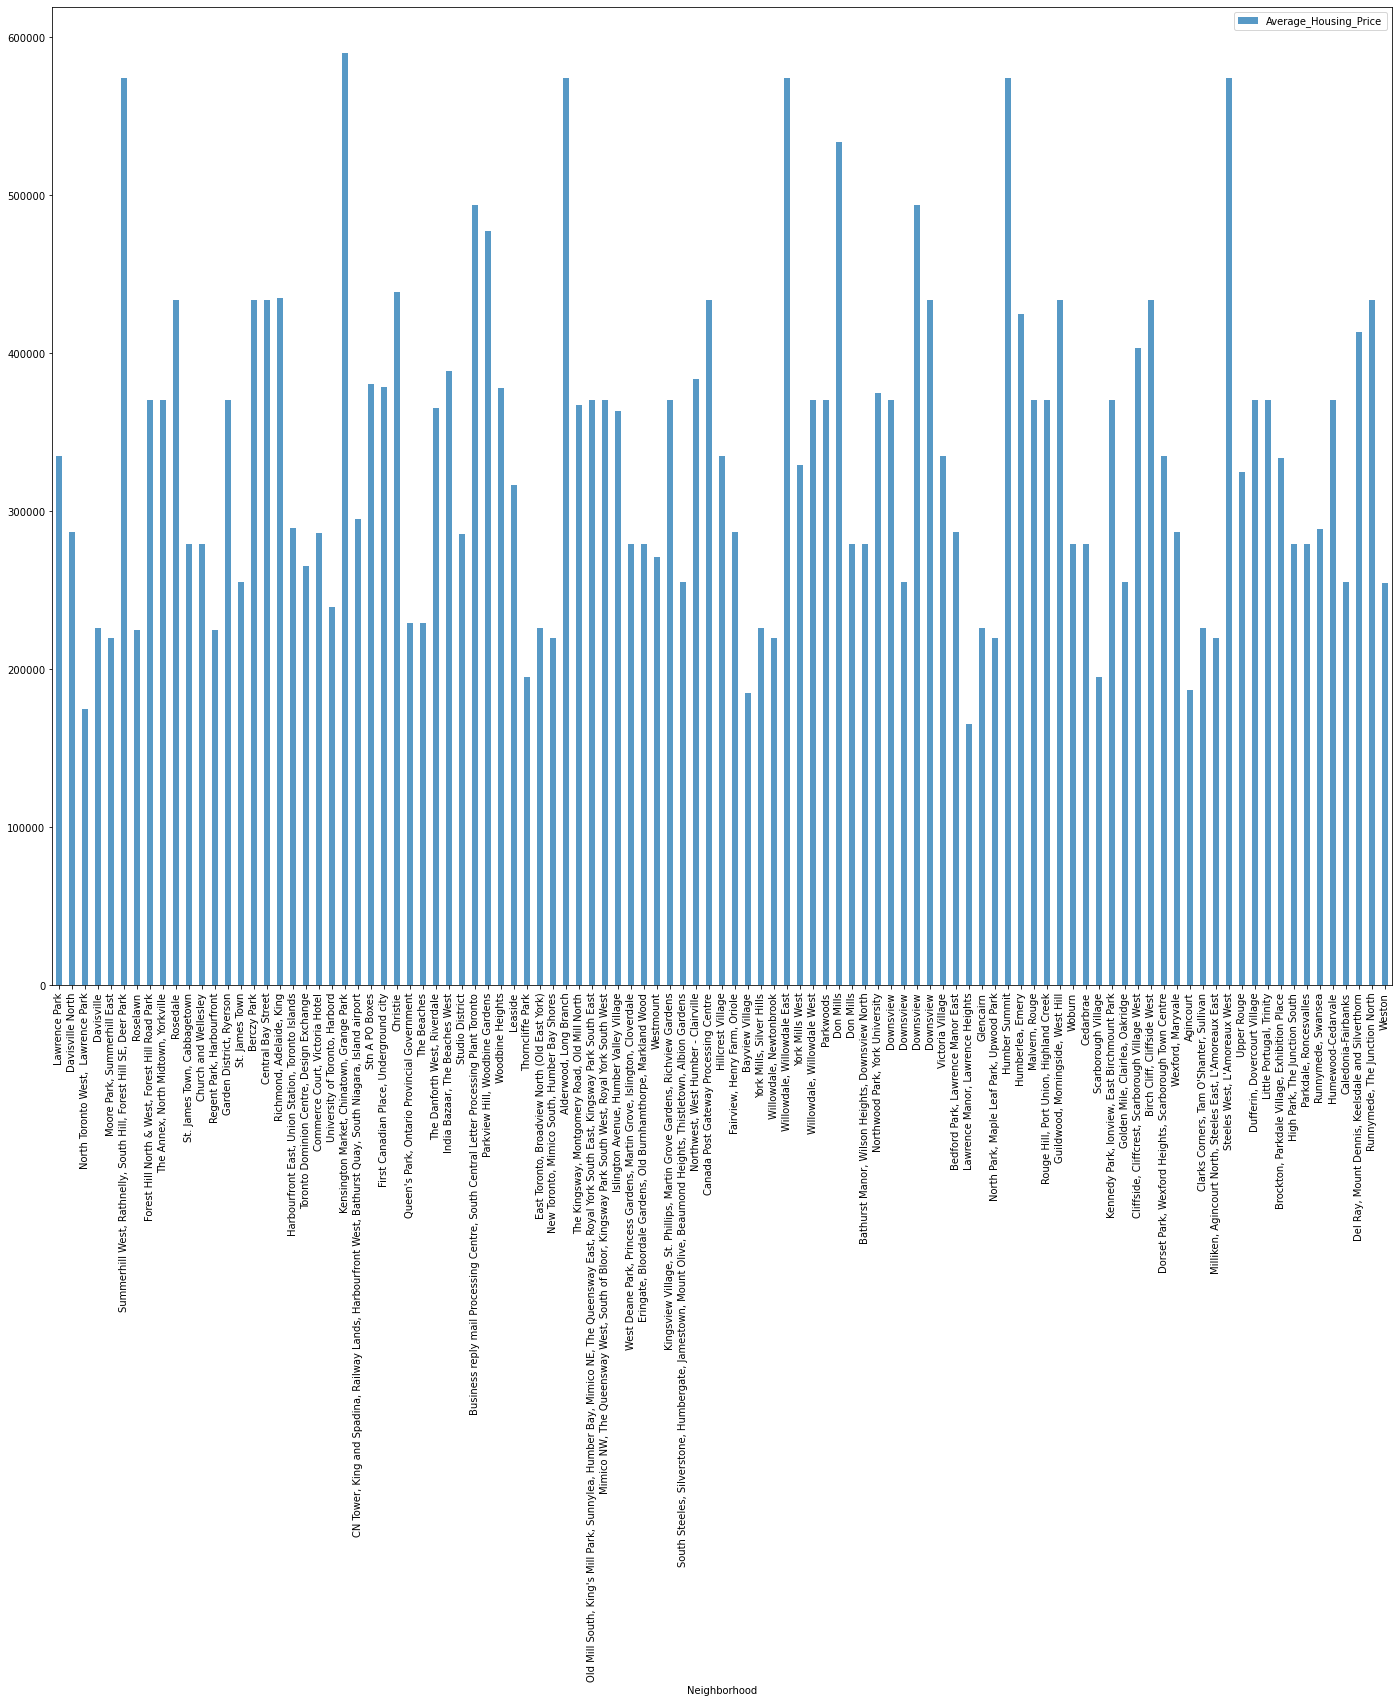

In [204]:
North_York_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [205]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [206]:
new_North_York=North_York_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
North_York_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [207]:
North_York_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

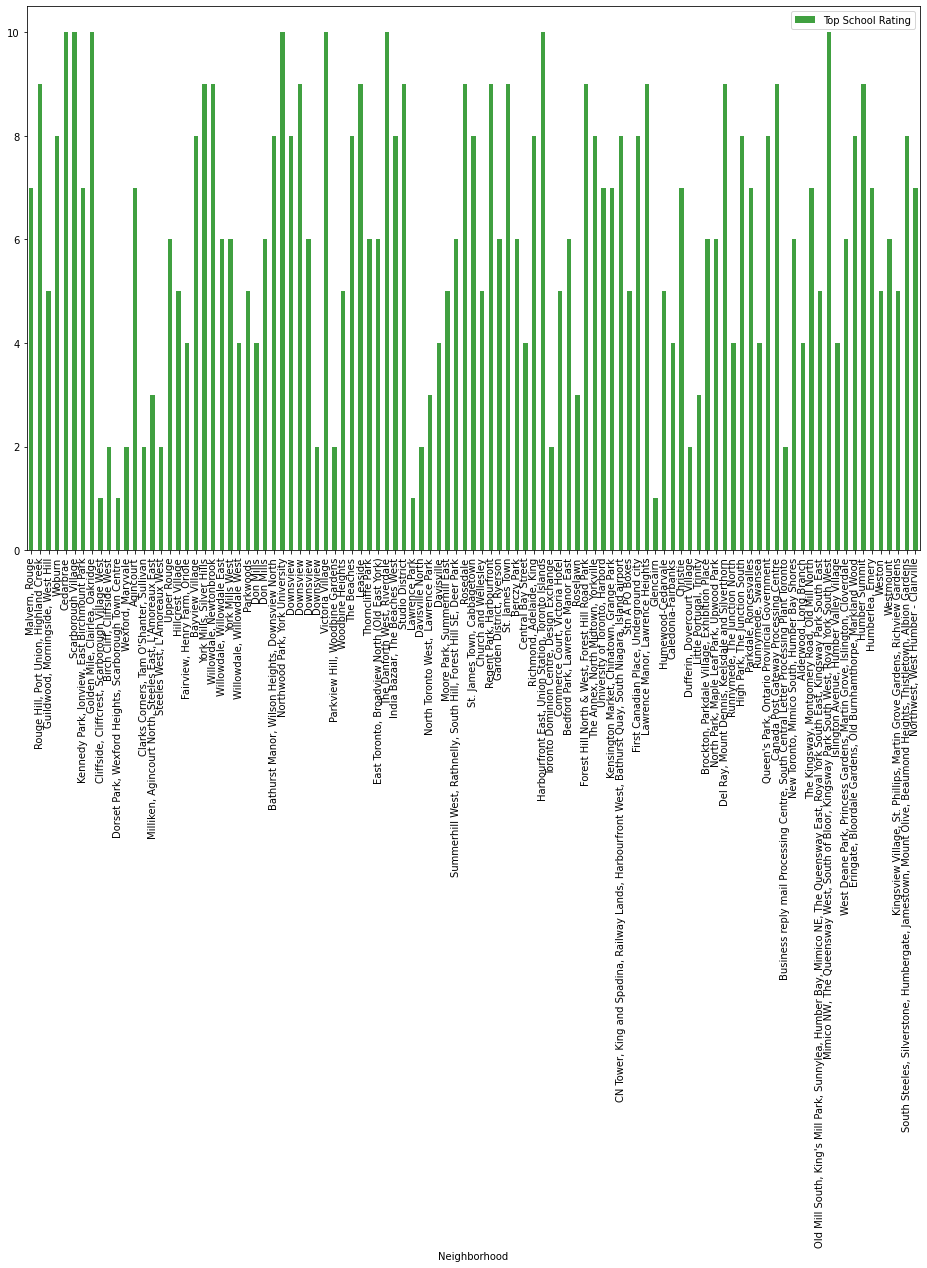

In [208]:
North_York_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);


### Conclusion:

- Using k-means cluster algorithm to separate the neighborhood into 10 different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. 

- The charts results showed particular neighborhood based on average house prices and school rating.

- Folium mapping is a very powerful technique to visualize and to consolidate information and make efficient good analysis and decision.

- We get a lot of information about the neighborhood in North York. There are 307 unique venues categories in North York and its nearby neighborhood such as shopping mall, bakery, pool, grocery store, pharmacy, restaurant, coffee shop, diner, bus line, gym center, gas station, etc.

- Looking at the data, we can analyze that there are so much diversity in the North York neighborhood. There are lot of school with great rating for children. The talk about North York is a good recommendation place to move can be supported with these data.

- The results can be checked from the map and the graph and they can be used for people who wants to move to North York to find good housing and good school.

- This Data Science project showed a practical application to resolve a real life situation that can bring personal and financial impact.

- This project can be improved by making it more accurate to find best house in North York to live with effective living cost.
